In [1]:
import torch
if(torch.cuda.is_available()):
    device = torch.device("cuda")
    print(device, torch.cuda.get_device_name(0))
else:
    device= torch.device("cpu")
    print(device)

cuda Tesla T4


In [2]:
import torch.nn as nn

In [3]:
class Flatten(nn.Module):
  def forward(self, input):
    return input.view(input.size(0), -1)

In [4]:
class UnFlatten(nn.Module):
  def forward(self, input, size=1024):
    return input.view(input.size(0), size, 1, 1)

In [5]:
class VAE(nn.Module):
  def __init__(self, image_channels=3, h_dim=1024, z_dim=64):
    super(VAE, self).__init__()
    self.encoder = nn.Sequential(
      nn.Conv2d(3, 32, kernel_size=2, stride=2),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(32, 64, kernel_size=2, stride=2),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(64, 128, kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(128, 256, kernel_size=2, stride=2),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(256, 512, kernel_size=2, stride=2),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(512, 1024, kernel_size=2, stride=2),
      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.Conv2d(1024, 1024, kernel_size=2, stride=2),
      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      Flatten()
    )
    self.fc1 = nn.Linear(h_dim, z_dim)
    self.fc2 = nn.Linear(h_dim, z_dim)
    self.fc3 = nn.Linear(z_dim, h_dim) 
    self.decoder = nn.Sequential(
      UnFlatten(),
      nn.ConvTranspose2d(1024, 1024, kernel_size=2, stride=2),
      nn.BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2),
      nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
      nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2),
      nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2),
      nn.BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(64, 32, kernel_size=2, stride=2),
      nn.BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.ReLU(),
      nn.ConvTranspose2d(32, 3, kernel_size=2, stride=2),
      nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
      nn.Sigmoid(),
    )
      
  def reparameterize(self, mu, logvar):
    std = logvar.mul(0.5).exp_()
    # return torch.normal(mu, std)
    esp = torch.randn(*mu.size())
    z = mu+std*esp.to(device)
    return z

  def bottleneck(self, h):
    mu, logvar = self.fc1(h), self.fc2(h)
    z = self.reparameterize(mu, logvar)
    return z, mu, logvar

  def encode(self, x):
    h=self.encoder(x)
    z,mu,logvar=self.bottleneck(h)
    return z, mu, logvar

  def decode(self, z):
    z = self.fc3(z)
    z = self.decoder(z)
    return z

  def forward(self, x):
    z, mu, logvar = self.encode(x)
    z = self.decode(z)
    return z, mu, logvar

In [6]:
model=VAE()
model.to(device)
print(model)

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_run

In [7]:
from torchsummary import summary
summary(model,(3,128,128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             416
       BatchNorm2d-2           [-1, 32, 64, 64]              64
              ReLU-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 64, 32, 32]           8,256
       BatchNorm2d-5           [-1, 64, 32, 32]             128
              ReLU-6           [-1, 64, 32, 32]               0
            Conv2d-7          [-1, 128, 16, 16]          32,896
       BatchNorm2d-8          [-1, 128, 16, 16]             256
              ReLU-9          [-1, 128, 16, 16]               0
           Conv2d-10            [-1, 256, 8, 8]         131,328
      BatchNorm2d-11            [-1, 256, 8, 8]             512
             ReLU-12            [-1, 256, 8, 8]               0
           Conv2d-13            [-1, 512, 4, 4]         524,800
      BatchNorm2d-14            [-1, 51

In [8]:
import torch.nn.functional as F

In [9]:
def loss_fn(recon_x, x, mu, logvar):
  #BCE = F.binary_cross_entropy(recon_x, x, size_average=False).to(device)
  MSE = F.mse_loss(recon_x, x, reduction='sum')
  # see Appendix B from VAE paper:
  # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
  # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
  KLD = -0.5*torch.mean(1+logvar-mu.pow(2)-logvar.exp()).to(device)
  return MSE+KLD, MSE, KLD

In [10]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

#Connect to Google drive

In [11]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [12]:
from torchvision import transforms
transformer = transforms.Compose([
  transforms.Resize((128, 128)),       
  transforms.ToTensor(),                     
  transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5] )])

In [13]:
from torchvision import datasets
train_dataset = datasets.ImageFolder(root = "/content/gdrive/MyDrive/Image folders/train", transform = transformer)

In [14]:
import torch.utils.data as Data
loader = Data.DataLoader(
    dataset=train_dataset,
    batch_size=16,
    shuffle=True)

#Try to send one batch of training images to VAE

In [15]:
for batchX, _ in loader:
  break;
print(batchX.shape)

torch.Size([16, 3, 128, 128])


### encoder

In [16]:
h = model.encoder(batchX.to(device))
print(h.shape)

torch.Size([16, 1024])


In [17]:
mu=model.fc1(h)
print(mu.shape)

torch.Size([16, 64])


In [18]:
logvar=model.fc2(h)
print(logvar.shape)

torch.Size([16, 64])


In [19]:
std = logvar.mul(0.5).exp_()
print(std.shape)

torch.Size([16, 64])


In [20]:
esp=torch.randn(*mu.size())
print(esp.shape)

torch.Size([16, 64])


In [21]:
z=mu+std*esp.to(device)
print(z.shape)

torch.Size([16, 64])


### decode

In [22]:
z = model.fc3(z)
print(z.shape)

torch.Size([16, 1024])


In [23]:
z = model.decoder(z)
print(z.shape)

torch.Size([16, 3, 128, 128])


### Pass input image batch to encoder+decoder together

In [24]:
tensorY,mu,logvar = model(batchX.to(device))
print(tensorY.shape)

torch.Size([16, 3, 128, 128])


In [25]:
loss, mse, kld = loss_fn(tensorY, batchX.to(device), mu, logvar)
print(loss)

tensor(658786.8750, device='cuda:0', grad_fn=<AddBackward0>)


In [26]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

#Training loop

In [27]:
model.train()
print("")

In [28]:
lossLst = []
for epoch in range(800):
  if(epoch%20==0):
    print("\nepoch = ", epoch, end = ", ")
    print("batch: ", end="")
  for step, (batchX, _) in enumerate(loader):
    if(epoch%20==0 and step%5==0):
      print(step, end = ",")
    tensorY,mu,logvar = model(batchX.to(device))
    loss, mse,kld = loss_fn(tensorY, batchX.to(device), mu, logvar)
    lossLst.append(float(loss))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()


epoch =  0, batch: 0,5,10,15,
epoch =  20, batch: 0,5,10,15,
epoch =  40, batch: 0,5,10,15,
epoch =  60, batch: 0,5,10,15,
epoch =  80, batch: 0,5,10,15,
epoch =  100, batch: 0,5,10,15,
epoch =  120, batch: 0,5,10,15,
epoch =  140, batch: 0,5,10,15,
epoch =  160, batch: 0,5,10,15,
epoch =  180, batch: 0,5,10,15,
epoch =  200, batch: 0,5,10,15,
epoch =  220, batch: 0,5,10,15,
epoch =  240, batch: 0,5,10,15,
epoch =  260, batch: 0,5,10,15,
epoch =  280, batch: 0,5,10,15,
epoch =  300, batch: 0,5,10,15,
epoch =  320, batch: 0,5,10,15,
epoch =  340, batch: 0,5,10,15,
epoch =  360, batch: 0,5,10,15,
epoch =  380, batch: 0,5,10,15,
epoch =  400, batch: 0,5,10,15,
epoch =  420, batch: 0,5,10,15,
epoch =  440, batch: 0,5,10,15,
epoch =  460, batch: 0,5,10,15,
epoch =  480, batch: 0,5,10,15,
epoch =  500, batch: 0,5,10,15,
epoch =  520, batch: 0,5,10,15,
epoch =  540, batch: 0,5,10,15,
epoch =  560, batch: 0,5,10,15,
epoch =  580, batch: 0,5,10,15,
epoch =  600, batch: 0,5,10,15,
epoch =  620,

KeyboardInterrupt: ignored

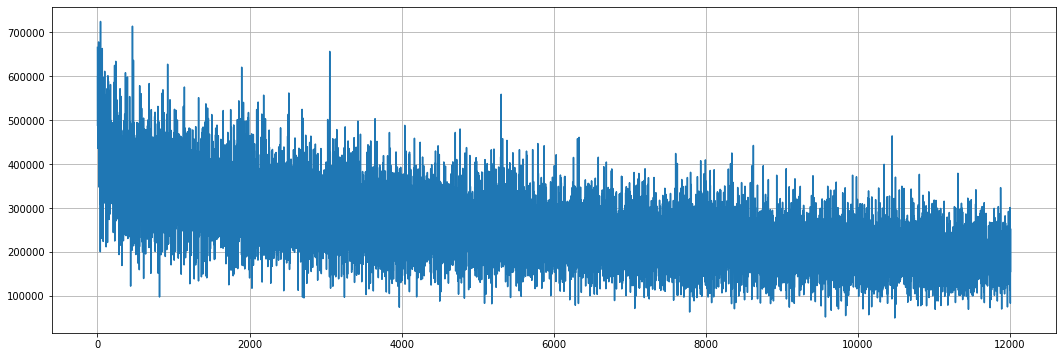

In [29]:
fig=plt.figure(figsize=(18, 6))
plt.plot(lossLst)
plt.grid()

#Test with training images

In [30]:
model.eval()
print("")

In [31]:
for batchX, _ in loader:
  break;
print(batchX.shape)

torch.Size([16, 3, 128, 128])


In [32]:
tensorY,mu,logvar = model(batchX.to(device))
print(tensorY.shape)

torch.Size([16, 3, 128, 128])


In [33]:
def ConvertTensorToArray (tensorInput):
  imgTensor = torchvision.utils.make_grid(tensorInput)
  imgArray = imgTensor.numpy() 
  imgArray1 = np.zeros((imgArray.shape[1], imgArray.shape[2], 3))
  imgArray1[:,:,0] = imgArray[0, :, :]  
  imgArray1[:,:,1] = imgArray[1, :, :]
  imgArray1[:,:,2] = imgArray[2, :, :]
  imgArray1 = imgArray1*0.5+0.5
  return imgArray1

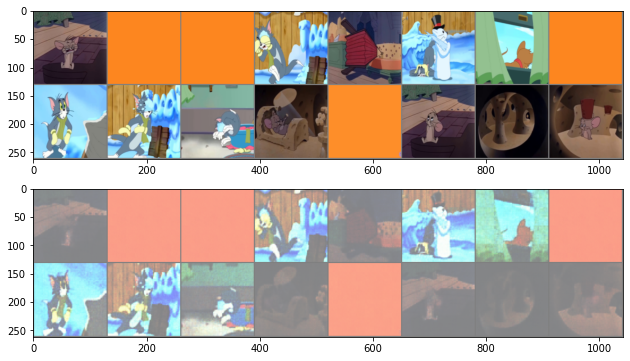

In [34]:
fig,axs=plt.subplots(2,1,figsize=(12,6))
imgArray=ConvertTensorToArray(batchX) 
axs[0].imshow(imgArray)
imgArray=ConvertTensorToArray(tensorY.cpu()) 
axs[1].imshow(imgArray)
plt.show()

#Test with un-seen test data

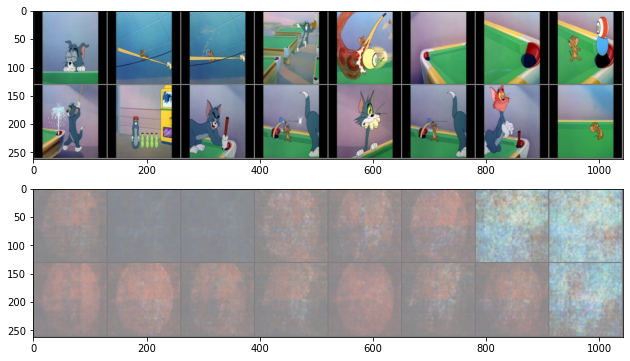

In [35]:
test_dataset = datasets.ImageFolder(root = "/content/gdrive/MyDrive/Image folders/test", transform = transformer)
loader = Data.DataLoader(
    dataset=test_dataset,
    batch_size=16,
    shuffle=True)
for batchX, _ in loader:
  break;
tensorY,mu,logvar = model(batchX.to(device))

fig,axs=plt.subplots(2,1,figsize=(12,6))
imgArray=ConvertTensorToArray(batchX) 
axs[0].imshow(imgArray)
imgArray=ConvertTensorToArray(tensorY.cpu()) 
axs[1].imshow(imgArray)
plt.show()

#Save and load a PyTorch model (if you want)

In [36]:
torch.save(model.state_dict(), "VAE800.pt")

In [37]:
model=VAE() #build NN architecture
model.load_state_dict(torch.load("VAE800.pt")) #load model weights
model.to(device)
model.eval()

VAE(
  (encoder): Sequential(
    (0): Conv2d(3, 32, kernel_size=(2, 2), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 64, kernel_size=(2, 2), stride=(2, 2))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Conv2d(64, 128, kernel_size=(2, 2), stride=(2, 2))
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU()
    (9): Conv2d(128, 256, kernel_size=(2, 2), stride=(2, 2))
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU()
    (12): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
    (13): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (14): ReLU()
    (15): Conv2d(512, 1024, kernel_size=(2, 2), stride=(2, 2))
    (16): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_run

# Try to pass a batch of training images to AE to get their latent vectors

In [38]:
loader=Data.DataLoader(
  dataset=train_dataset,
  batch_size=16,
  shuffle=True)

In [39]:
for batchX, batchY in loader:
  break;
print(batchX.shape)

torch.Size([16, 3, 128, 128])


In [40]:
z, mu, logvar = model.encode(batchX.to(device))
print(z.shape, mu.shape, logvar.shape)

torch.Size([16, 64]) torch.Size([16, 64]) torch.Size([16, 64])


### sample z from mu and std

In [41]:
std = logvar.mul(0.5).exp_()
print(std.shape)

torch.Size([16, 64])


In [42]:
from torch.distributions import Normal
dist=Normal(mu, std)

In [43]:
z1=dist.sample()
print(z1.shape)

torch.Size([16, 64])


In [44]:
z1.cpu().detach().numpy().shape

(16, 64)

### compare z and z1

In [45]:
idx = 2
print(z[idx], "\n", z1[idx])

tensor([-0.3255, -1.5249,  0.1831, -1.1215, -1.1529,  1.1957,  1.7094,  0.7007,
         0.6298, -0.7499, -0.0291,  1.0370, -1.8371,  0.6807,  0.2536, -2.4677,
        -1.1633,  0.2192,  0.7117,  2.4683, -0.7973, -0.8318, -0.1091,  0.8612,
        -0.5179,  2.2538,  0.3618, -0.1874,  0.0552, -1.5426, -1.7916, -0.1742,
        -0.2334,  0.8577, -1.7771, -0.0199,  0.9605, -3.5429, -1.0918, -2.3850,
         0.6462,  0.3517,  0.9861,  0.7022,  0.4560, -1.6366, -1.5980,  0.4873,
        -2.5308, -1.4840, -0.5159, -1.3783,  0.3960, -1.0005,  0.1520,  3.2218,
        -1.0918,  0.5215, -0.3989,  0.4035,  0.0165,  0.3562,  0.1565,  0.3826],
       device='cuda:0', grad_fn=<SelectBackward>) 
 tensor([-0.3121, -1.5227,  0.1753, -1.1132, -1.1622,  1.1965,  1.7241,  0.7041,
         0.6372, -0.7504, -0.0327,  1.0438, -1.8337,  0.6764,  0.2501, -2.4675,
        -1.1731,  0.2337,  0.7043,  2.4737, -0.8079, -0.8336, -0.1167,  0.8535,
        -0.5189,  2.2530,  0.3726, -0.1865,  0.0491, -1.5440, -1.79

# Get the latent vectors of all training images

In [46]:
for step, (batchX, batchY) in enumerate(loader):
  z, mu, logvar = model.encode(batchX.to(device))
  std = logvar.mul(0.5).exp_()
  dist=Normal(mu, std)
  z1=dist.sample()
  if(step==0):
    arrayX = np.array(z1.cpu().detach().numpy())
    arrayY = batchY.cpu().detach().numpy()
  else:
    arrayX = np.concatenate((arrayX, z1.cpu().detach().numpy()))
    arrayY = np.concatenate((arrayY, batchY.cpu().detach().numpy()))
print(arrayX.shape, arrayY.shape)

(298, 64) (298,)


# t-SNE to reduce dimensions from 64 to 2 so we can visualize

In [47]:
from sklearn.manifold import TSNE
tsne = TSNE(perplexity=5, n_components=2, init='pca', n_iter=5000)
# try perlexity = 5, 10, 30, 50

In [48]:
x=tsne.fit_transform(arrayX)
print(x.shape)

(298, 2)


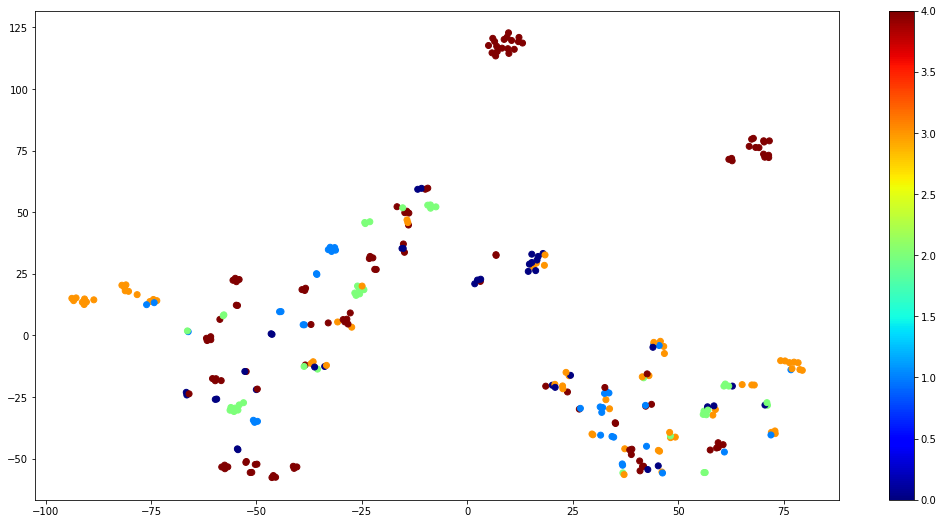

In [49]:
plt.figure(figsize=(18,9))
plt.scatter(x[:, 0], x[:, 1], c=arrayY, cmap="jet") #we have 5 classes
plt.colorbar()
plt.show()

# Save data to csv for Tableau visual exploration

In [50]:
print(x.shape, arrayY.shape)

(298, 2) (298,)


In [51]:
arrayY1 = arrayY.reshape(arrayY.shape[0], 1)
print(arrayY1.shape)

(298, 1)


In [52]:
XYArray = np.hstack((x, arrayY1))
print(XYArray.shape)

(298, 3)


In [53]:
# Save data to excel for further Tableau visualization
import pandas as pd 
pd.DataFrame(XYArray).to_csv("tSNE.csv")